In [1]:
pip install tensorflow pycocotools opencv-python matplotlib

  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.12.2
    Uninstalling typing-extensions-4.12.2:
      Successfully uninstalled typing-extensions-4.12.2
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\ASUS\AppData\Local\Progr

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
📢 Total Images in Dataset: 80
✅ Train Set: 64 images
✅ Validation Set: 16 images
📸 Showing Image: 05.jpg


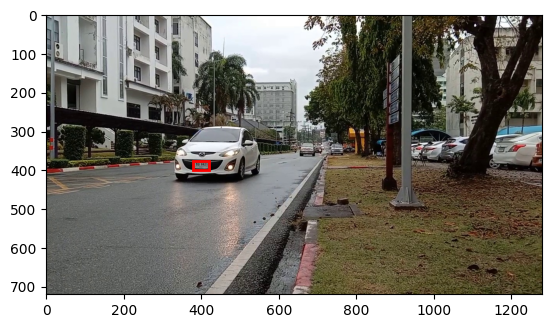

In [3]:
import os
import json
import numpy as np
import cv2
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

# 📌 ตั้งค่าที่อยู่ของ dataset (เปลี่ยนตามโฟลเดอร์ของคุณ)
dataDir = 'C://Users//ASUS//Desktop//Mini_project_ML//Dataset//coco'  # โฟลเดอร์หลักของ dataset
annFile = os.path.join(dataDir, 'annotations', 'instances_train.json')  # ไฟล์ annotation ที่ export จาก CVAT
imgDir = os.path.join(dataDir, 'images', 'train')  # ที่อยู่ของรูปภาพ (เปลี่ยนตามโครงสร้างของคุณ)

# 📌 โหลด COCO Annotation
coco = COCO(annFile)

# 📌 โหลด ID ของภาพทั้งหมด
imgIds = coco.getImgIds()
print(f"📢 Total Images in Dataset: {len(imgIds)}")

# 📌 แบ่ง train/val (80% train, 20% val)
split_ratio = 0.8
split_idx = int(len(imgIds) * split_ratio)

train_imgIds = imgIds[:split_idx]
val_imgIds = imgIds[split_idx:]

print(f"✅ Train Set: {len(train_imgIds)} images")
print(f"✅ Validation Set: {len(val_imgIds)} images")

# 📌 ฟังก์ชันโหลดภาพและ annotation
def load_image_and_annotations(img_id):
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(imgDir, img_info['file_name'])  # ปรับ path ให้ตรงกับโครงสร้างของคุณ
    
    # โหลดภาพ
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # เปลี่ยนสีจาก BGR เป็น RGB
    
    # โหลด annotation สำหรับภาพนี้
    ann_ids = coco.getAnnIds(imgIds=img_id)
    annotations = coco.loadAnns(ann_ids)
    
    return image, annotations, img_info

# 📌 ฟังก์ชันแสดงภาพพร้อม Bounding Box
def show_image_with_annotations(image, annotations):
    plt.imshow(image)
    ax = plt.gca()
    
    # วาด Bounding Box
    for ann in annotations:
        bbox = ann['bbox']  # bbox อยู่ในรูปแบบ [x, y, width, height]
        x, y, w, h = bbox
        ax.add_patch(plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
    
    plt.show()

# 📌 ทดสอบโหลดภาพจาก train set
sample_img_id = train_imgIds[4]  # เลือกภาพแรกจาก train
image, annotations, img_info = load_image_and_annotations(sample_img_id)

print(f"📸 Showing Image: {img_info['file_name']}")
show_image_with_annotations(image, annotations)


In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

# 📌 ตั้งค่าที่อยู่ของ dataset (เปลี่ยนตามโฟลเดอร์ของคุณ)
dataDir = 'C://Users//ASUS//Desktop//Mini_project_ML//Dataset//coco'
annFile = os.path.join(dataDir, 'annotations', 'instances_train.json')
imgDir = os.path.join(dataDir, 'images', 'train')

# 📌 โหลด COCO Annotation
coco = COCO(annFile)

# 📌 โหลด ID ของภาพทั้งหมด
imgIds = coco.getImgIds()
print(f"📢 Total Images in Dataset: {len(imgIds)}")

# 📌 แบ่ง train/val (80% train, 20% val)
split_ratio = 0.8
split_idx = int(len(imgIds) * split_ratio)

train_imgIds = imgIds[:split_idx]
val_imgIds = imgIds[split_idx:]

print(f"✅ Train Set: {len(train_imgIds)} images")
print(f"✅ Validation Set: {len(val_imgIds)} images")

# 📌 ฟังก์ชันโหลดภาพและเตรียมข้อมูล
def load_data(imgIds):
    images = []
    bboxes = []

    for img_id in imgIds:
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(imgDir, img_info['file_name'])

        # ✅ โหลดภาพและ resize เป็น (224, 224)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image / 255.0  # Normalize to [0,1]

        # ✅ โหลด annotation
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        # ✅ ดึง bounding box (ใช้แค่ bbox แรกของแต่ละภาพ)
        if len(annotations) > 0:
            bbox = annotations[0]['bbox']
            x, y, w, h = bbox

            # Normalize bounding box เป็น [0,1]
            x /= img_info['width']
            y /= img_info['height']
            w /= img_info['width']
            h /= img_info['height']
        else:
            x, y, w, h = 0, 0, 0, 0  # ถ้าไม่มี bbox, กำหนดเป็นศูนย์

        images.append(image)
        bboxes.append([x, y, w, h])

    return np.array(images), np.array(bboxes)

# 📌 โหลด train และ val data
X_train, y_train = load_data(train_imgIds)
X_val, y_val = load_data(val_imgIds)

print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# 📌 สร้างโมเดล CNN
def create_model(input_shape=(224, 224, 3)):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    
    # Output layer สำหรับ bounding box (x, y, w, h)
    model.add(layers.Dense(4, activation='sigmoid'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 📌 สร้างโมเดล
model = create_model()
model.summary()

# 📌 เทรนโมเดล
# history = model.fit(
#     X_train, y_train,
#     epochs=10,
#     batch_size=16,
#     validation_data=(X_val, y_val)
# )


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
📢 Total Images in Dataset: 80
✅ Train Set: 64 images
✅ Validation Set: 16 images
✅ X_train shape: (64, 224, 224, 3), y_train shape: (64, 4)
✅ X_val shape: (16, 224, 224, 3), y_val shape: (16, 4)


c:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
!pip install torch torchvision


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!python.exe -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ---------------------------- ----------- 1.3/1.8 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.3.1
    Uninstalling pip-24.3.1:
      Successfully uninstalled pip-24.3.1


In [9]:
!pip install --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/networkx-3.3-py3-none-any.whl.metadata (5.1 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2024.6.1-py3-none-any.whl.metadata (11 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
   ---------------------------------------- 0.0/206.5 MB ? eta -:--:--
   ---------------------------------------- 1.8/206.5 MB 10.1 MB/s eta 0:00:21
    --------------------------------------- 4.5/206.5 MB 11.2 MB/s eta 0:00:19
   - -------------------------------------- 7.1/206.5 MB 11.5 MB/s eta 0:00:18
   - -------------------------------------- 9.4/206.5 MB 11.5 MB/s eta 0:00:18
   -- ------------------------------------- 12.1/206.5 MB 11.6 MB/s eta 0:00:17
   -- ------------------------------------- 14.4/206.5 MB 11.6 MB/s eta 0:00:17
   --- ---------------------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.1.1 requires numpy<2.0,>=1.16; python_version <= "3.11", but you have numpy 2.1.2 which is incompatible.
label-studio 1.15.0 requires numpy<2.0.0,>=1.26.4, but you have numpy 2.1.2 which is incompatible.
label-studio-sdk 1.0.8 requires numpy<2.0.0, but you have numpy 2.1.2 which is incompatible.
numba 0.59.0 requires numpy<1.27,>=1.22, but you have numpy 2.1.2 which is incompatible.
pycaret 3.2.0 requires numpy<1.27,>=1.21, but you have numpy 2.1.2 which is incompatible.
pycaret 3.2.0 requires pandas<2.0.0,>=1.3.0, but you have pandas 2.2.3 which is incompatible.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have 

In [8]:
import random
import os
import cv2
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO

# ตรวจสอบว่าใช้ GPU ได้หรือไม่
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# กำหนด path ให้ตรงกับโฟลเดอร์ในเครื่อง
dataDir = 'C://Users//ASUS//Desktop//Mini_project_ML//Dataset//coco'  # โฟลเดอร์หลักของ dataset
annFile = os.path.join(dataDir, 'annotations', 'instances_train.json')  # ไฟล์ annotation ที่ export จาก CVAT
imgDir = os.path.join(dataDir, 'images', 'train')  # ที่อยู่ของรูปภาพ (เปลี่ยนตามโครงสร้างของคุณ)

# โหลด COCO dataset
coco = COCO(annFile)
all_imgIds = coco.getImgIds()

if len(all_imgIds) == 0:
    raise ValueError("ไม่พบภาพใน COCO dataset! ตรวจสอบ path ของไฟล์ JSON")

# สุ่มและแบ่งข้อมูล (80% train, 20% val)
random.shuffle(all_imgIds)
split_idx = int(0.8 * len(all_imgIds))
train_imgIds = all_imgIds[:split_idx]
val_imgIds = all_imgIds[split_idx:]

print(f"Train set: {len(train_imgIds)} images")
print(f"Validation set: {len(val_imgIds)} images")

AttributeError: module 'torch' has no attribute 'version'